In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import random
import os
import pickle
from sklearn import metrics
from datetime import date
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import numpy as np
from plotly.subplots import make_subplots
import seaborn as sns

In [2]:
df = pd.read_csv(r'D:\Customer_Value\data\prediction\prediction_residual_0302.csv')
# df1 = pd.read_csv(r'D:\Customer_Value\data\prediction\prediction_large_0227_2.csv')
# df = pd.concat([df, df1], axis=0)

In [7]:
def predict(row, threshold):
    
    if row['LABEL_CHURN_1_score.1'] > threshold:
        return 1
    elif row['LABEL_CHURN_0_score.1'] > threshold:
        return 0
    else:
        return -1

In [8]:
def Evaluation(data, threshold=0.5):
    
    d = data.copy()
    d['prediction'] = d.apply(predict, threshold=threshold, axis=1)
    d = d[d.prediction != -1]
    accuracy = metrics.accuracy_score(d['LABEL_CHURN'], d['prediction'])

    target_names = ['ACTIVE', 'CHURN']
    report = classification_report(d['LABEL_CHURN'].tolist(), d['prediction'].tolist(), target_names=target_names)
    up_support = len(data[data.LABEL_CHURN_1_score > threshold])
    down_support = len(data[data.LABEL_CHURN_0_score > threshold])
    up_support_ratio = len(data[data.LABEL_CHURN_1_score > threshold]) / len(data)
    down_support_ratio = len(data[data.LABEL_CHURN_0_score > threshold]) / len(data)

    return [accuracy, report, up_support, down_support, up_support_ratio, down_support_ratio]

In [9]:
df

,AGE,AMT_B_day1,AMT_B_day10,AMT_B_day100,AMT_B_day101,AMT_B_day102,AMT_B_day103,AMT_B_day104,AMT_B_day105,AMT_B_day106,...,TRADE_day93,TRADE_day94,TRADE_day95,TRADE_day96,TRADE_day97,TRADE_day98,TRADE_day99,sample_no,LABEL_CHURN_0_score.1,LABEL_CHURN_1_score.1
0,43,0,0,0,264400,200250,140650,193350,149600,154800,...,0,1,0,0,0,1,0,R222818718_1,0.906938,0.093062
1,66,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,L101474577_0,0.956980,0.043020
2,63,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,Y220012964_0,0.927018,0.072982
3,28,0,0,67700,0,0,0,0,0,0,...,0,0,0,0,0,0,0,N224352523_0,0.939233,0.060767
4,35,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,O200123326_0,0.937655,0.062345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5170,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Q124549688_0,0.935219,0.064781
5171,54,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,H221248199_0,0.955143,0.044857
5172,42,0,0,0,0,0,0,0,0,48200,...,0,0,0,0,0,0,0,Q222617881_1,0.958101,0.041899
5173,53,0,0,0,0,216000,0,0,0,0,...,0,0,0,0,0,0,0,Q121495085_0,0.956165,0.043835


In [10]:
result = Evaluation(df, threshold=0.5)
print(result[0])
print(result[1])

0.8995169082125604
              precision    recall  f1-score   support

      ACTIVE       0.90      1.00      0.95      4648
       CHURN       0.82      0.02      0.03       527

    accuracy                           0.90      5175
   macro avg       0.86      0.51      0.49      5175
weighted avg       0.89      0.90      0.85      5175



In [6]:
def read_original_data(df_path):
    
    data = pd.read_csv(df_path)
    df_list = [group[1] for group in data.groupby(data['sample_no'])]
    d = pd.concat([pd.DataFrame(data.iloc[-1]).transpose() for data in df_list], axis=0)
    
    return d

In [17]:
data = read_original_data(r'D:\Customer_Value\data\evaluate\st_sample_all.csv')

In [8]:
def find_false_prediction(prediction_data, original_data, threshold=0.5):
    
    df = pd.merge(prediction_data[['LABEL_CHURN_1_score', 'LABEL_CHURN_0_score', 'sample_no']], original_data, how='inner', on='sample_no')
    
    df['prediction'] = df.apply(predict, threshold=threshold, axis=1)
    df = df[df.prediction != -1] 
    false_negative = df[(df.LABEL_CHURN == 'CHURN') & (df.prediction == 0)]
    false_positive = df[(df.LABEL_CHURN == 'ACTIVE') & (df.prediction == 1)]
    
    return false_negative, false_positive

In [28]:
fn, fp = find_false_prediction(df, data)

In [29]:
churn = data[data.LABEL_CHURN == 'CHURN']
active = data[data.LABEL_CHURN == 'ACTIVE']

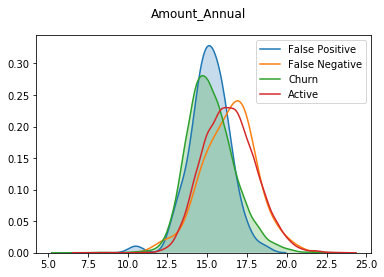

In [52]:
fig = sns.kdeplot(np.log(fp['amount_annual'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(fn['amount_annual'].astype(np.float64)), legend=False)
fig = sns.kdeplot(np.log(churn['amount_annual'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(active['amount_annual'].astype(np.float64)), legend=False)
fig.legend(labels=['False Positive','False Negative', 'Churn', 'Active'])
fig.figure.suptitle("Amount_Annual", fontsize = 12)
plt.show()

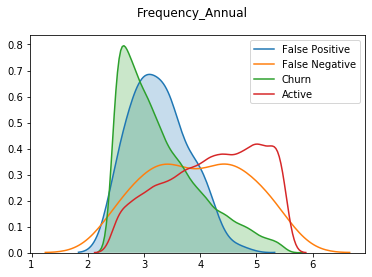

In [53]:
fig = sns.kdeplot(np.log(fp['frequency_annual'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(fn['frequency_annual'].astype(np.float64)), legend=False)
fig = sns.kdeplot(np.log(churn['frequency_annual'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(active['frequency_annual'].astype(np.float64)), legend=False)
fig.legend(labels=['False Positive','False Negative', 'Churn', 'Active'])
fig.figure.suptitle("Frequency_Annual", fontsize = 12)
plt.show()

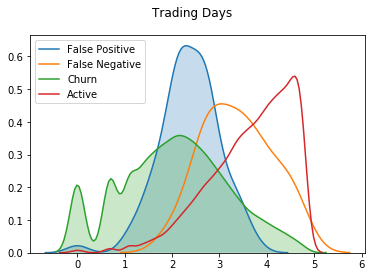

In [54]:
fig = sns.kdeplot(np.log(fp['trading_days_total_120_days'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(fn['trading_days_total_120_days'].astype(np.float64)), legend=False)
fig = sns.kdeplot(np.log(churn['trading_days_total_120_days'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(active['trading_days_total_120_days'].astype(np.float64)), legend=False)
fig.legend(labels=['False Positive','False Negative', 'Churn', 'Active'])
fig.figure.suptitle("Trading Days", fontsize = 12)
plt.show()

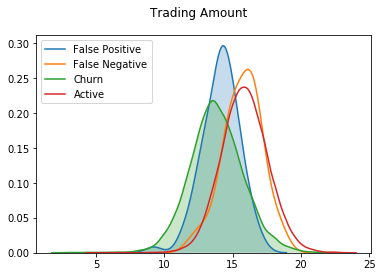

In [55]:
fig = sns.kdeplot(np.log(fp['trading_days_amount_120_days'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(fn['trading_days_amount_120_days'].astype(np.float64)), legend=False)
fig = sns.kdeplot(np.log(churn['trading_days_amount_120_days'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(active['trading_days_amount_120_days'].astype(np.float64)), legend=False)
fig.legend(labels=['False Positive','False Negative', 'Churn', 'Active'])
fig.figure.suptitle("Trading Amount", fontsize = 12)
plt.show()

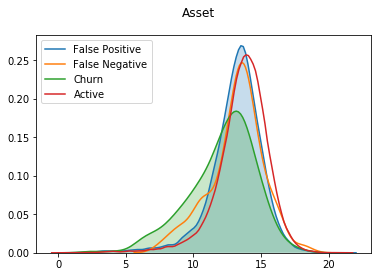

In [27]:
fig = sns.kdeplot(np.log(fp['ST_ASSET'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(fn['ST_ASSET'].astype(np.float64)), legend=False)
fig = sns.kdeplot(np.log(churn['ST_ASSET'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(active['ST_ASSET'].astype(np.float64)), legend=False)
fig.legend(labels=['False Positive','False Negative', 'Churn', 'Active'])
fig.figure.suptitle("Asset", fontsize = 12)
plt.show()

In [25]:
fp = df[(df.LABEL_CHURN_1_score >= 0.5) & (df.LABEL_CHURN == 0)]
churn = df[df.LABEL_CHURN == 1]
fn = df[(df.LABEL_CHURN_0_score >= 0.5) & (df.LABEL_CHURN == 1)]
active = df[df.LABEL_CHURN == 0]

In [26]:
fig = sns.kdeplot(np.log(fp['ST_ASSET_day120'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(fn['ST_ASSET_day120'].astype(np.float64)), legend=False)
fig = sns.kdeplot(np.log(churn['ST_ASSET_day120'].astype(np.float64)), shade=True, legend=False)
fig = sns.kdeplot(np.log(active['ST_ASSET_day120'].astype(np.float64)), legend=False)
fig.legend(labels=['False Positive','False Negative', 'Churn', 'Active'])
fig.figure.suptitle("Asset", fontsize = 12)
plt.show()

KeyError: 'ST_ASSET_day120'

Reconstruct false positive training set

In [28]:
train = pd.read_csv(r'D:\Customer_Value\data\train_google\train_feature.csv')

In [29]:
train_churn = train[train.LABEL_CHURN == 1]
len(train_churn)

21132

In [30]:
false_positive = pd.concat([train_churn, fp], axis=0)
false_positive

C:\Users\011553\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




,AGE,AMT_B,AMT_B_total_day10,AMT_B_total_day100,AMT_B_total_day100_diff,AMT_B_total_day110,AMT_B_total_day110_diff,AMT_B_total_day120,AMT_B_total_day120_diff,AMT_B_total_day20,...,ST_ASSET_total_day60_diff,ST_ASSET_total_day70,ST_ASSET_total_day70_diff,ST_ASSET_total_day80,ST_ASSET_total_day80_diff,ST_ASSET_total_day90,ST_ASSET_total_day90_diff,sample_no,trading_days_amount_120_days,trading_days_total_120_days
4,82.0,140000.0,0.0,0.0,0.0,0.0,0.0,140000.0,140000.0,0.0,...,53820.0,16636230.0,1256432.0,17044415.0,408185.0,17299439.0,255024.0,A100027173_0,1016400.0,5.0
5,87.0,0.0,0.0,0.0,0.0,0.0,0.0,19540.0,19540.0,0.0,...,4704.0,223440.0,288.0,222624.0,-816.0,230832.0,8208.0,A100099740_0,41540.0,2.0
6,67.0,0.0,1894000.0,1115000.0,-2357500.0,1662000.0,547000.0,4350000.0,2688000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A100106875_0,70141200.0,28.0
8,67.0,129000.0,765000.0,74000.0,74000.0,0.0,-74000.0,129000.0,129000.0,1992200.0,...,21344000.0,27870000.0,-554000.0,27912100.0,42100.0,28026600.0,114500.0,A100110486_0,8975800.0,11.0
9,90.0,137000.0,0.0,192400.0,192400.0,176000.0,-16400.0,277000.0,101000.0,262300.0,...,92100.0,6076800.0,-497100.0,6446050.0,369250.0,6338200.0,-107850.0,A100113718_0,3345550.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146528,58.0,235000.0,0.0,0.0,0.0,122000.0,122000.0,235000.0,113000.0,0.0,...,-2036873.0,8416338.0,1858758.0,8400460.0,-15878.0,7228405.0,-1172055.0,D120891501_0,893700.0,7.0
146565,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1684003.0,5050150.0,439000.0,4754650.0,-295500.0,5081650.0,327000.0,R201653977_1,1414500.0,4.0
146570,38.0,55050.0,18800.0,0.0,0.0,0.0,0.0,96950.0,96950.0,0.0,...,-3019756.0,3235126.0,1186694.0,3849069.0,613943.0,3670396.0,-178673.0,N224113213_0,1947475.0,18.0
146582,39.0,0.0,121500.0,0.0,0.0,0.0,0.0,153000.0,153000.0,37350.0,...,349109.0,14871883.0,696126.0,15280990.0,409107.0,14647222.0,-633768.0,H222554865_2,1001450.0,14.0


In [32]:
false_positive.to_csv(r'D:\Customer_Value\data\train_residual\fp_train_feature.csv', index=False)